In [2231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import cv2
import struct

In [2232]:
exp_dir = "../experiments/rocket/nov_28/t2"

In [2233]:
desc = yaml.load(open(exp_dir + "/desc.yaml"), yaml.Loader)

In [2234]:
def opencv_matrix(loader, node):
    mapping = loader.construct_mapping(node, deep=True)
    mat = np.array(mapping["data"])
    mat.resize(mapping["rows"], mapping["cols"])
    return mat

def load_camera_k_d(path):
    t = open(path, "r").read()
    t = t.replace("%YAML:1.0", "")
    yaml.add_constructor(u"tag:yaml.org,2002:opencv-matrix", opencv_matrix)
    return (lambda x: (x["K"], x["D"][0], (x["cam_width"], x["cam_height"])))(yaml.load(t, Loader=yaml.FullLoader))



In [2235]:
calib_0 = load_camera_k_d("calibs/" + desc["camera_0"] + ".yaml")
calib_1 = load_camera_k_d("calibs/" + desc["camera_1"] + ".yaml")

In [2236]:
# f = open(sys.argv[1], "rb")
def load_logger_data(p) -> pd.DataFrame:
    f = open(p, "rb")
    data = []
    N = 4 + 4*10
    while True:
        b = f.read(N)
        if b is None:
            break
        if len(b) != N:
            break
        # print(b)
        data.append(struct.unpack("<Lffffffffff", b))
    f = open("out.csv", "w")
    f.write("T ms, P pa\n")
    for i in data:
        f.write(f"{i[0]},{i[-1]}\n")
    # print(data, len(data))  

    D = np.array([i for i in data])
    D[:, 0] /= 1000
    df = pd.DataFrame(D, columns=["t", "gx", "gy", "gz", "ax", "ay", "az", "mx", "my", "mz", "P"])
    df["h"] = -np.log(df["P"]) *8.31*(273.15 + desc["T"])/9.8/(29/1000)
    df["h"] -= df["h"].iloc[:4].mean()
    return df

In [2237]:
markers = list(desc["markers"].keys())
markers

['light_1_a', 'light_1_b', 'light_2_a', 'light_2_b']

In [2238]:
markers_obj_pnts = np.array([desc["markers"][m]["pnt"] for m in markers])
markers_obj_pnts

array([[ 0.  ,  0.  ,  1.05],
       [ 0.  ,  0.  ,  4.43],
       [12.5 ,  0.  ,  1.05],
       [12.5 ,  0.  ,  4.43]])

In [2239]:
def get_track_path(v):
    return ".".join(v.split(".")[:-1]) + ".txt"

In [2240]:
def load_track_txt(track_txt_path, calib) -> pd.DataFrame:
    # track_txt_path = "../experiments/rocket/nov_28/t1/VID_20241129_011318_2.txt"
    f = open(track_txt_path, "r")
    f.readline()
    l1 = f.readline()[:-2]
    l2 = f.readline()[:-2] # x = -y
    track_names = [i for i in l1.split("\t") if i != ""]
    columns = l2.split("\t")

    cn_per_track = int( (len(columns) - 1) / len(track_names) )

    for i in range(1, len(columns)):
        columns[i] = track_names[(i-1)//cn_per_track] + "__" + columns[i]


    data = np.array([[float('nan') if j == "" else float(j.strip())  for j in i[:-1].split("\t")]for i in f.readlines()])

    df = pd.DataFrame(data, columns=columns)
    # df.copy()
    for tn in track_names:
        df[tn + "__pixelx"], df[tn + "__pixely"] = df[tn + "__pixely"], calib[2][1] -df[tn + "__pixelx"]
    # df["px"] = df[""]
    return df

In [2241]:
def interpolate_markers(df) -> pd.DataFrame:
    out = df.copy()
    out[[i for i in df.columns if "light" in i]] = out[[i for i in out.columns if "light" in i]].interpolate(method="linear", limit_direction="both")
    return out
def interpolate_rocket(df, limit=15) -> pd.DataFrame:
    out = df.copy()
    out[[i for i in df.columns if "A_" in i]] = out[[i for i in out.columns if "A_" in i]].interpolate(method="linear", limit_direction="backward", limit=limit)
    return out

In [2242]:
def interpolate_data_frame_to_new_t(df, t_new) -> pd.DataFrame:
    return pd.DataFrame({
        c: np.interp(t_new, df["t"], df[c])
        for c in df.columns
    })

In [2243]:
def get_marker_img_pnts(df: pd.DataFrame) -> np.ndarray:
    xx = np.expand_dims(df[[m + "__pixelx" for m in markers]].to_numpy(), axis=2)
    yy = np.expand_dims(df[[m + "__pixely" for m in markers]].to_numpy(), axis=2)
    return np.concatenate([xx, yy], axis=2)

def get_track_img_pnt(df: pd.DataFrame, track="A") -> np.ndarray:
    return df[[track+"__pixelx", track+"__pixely"]].to_numpy()


In [2244]:
def calculate_camera_pose(marker_img, calib):
    ret, rvec, tvec = cv2.solvePnP(markers_obj_pnts.astype(np.float64), marker_img.astype(np.float64), 
                                   calib[0].astype(np.float64), calib[1].astype(np.float64), 
                                           flags=cv2.SOLVEPNP_IPPE
                                           )

    print("ret", ret, "rvec", rvec, "tvec", tvec)
    R, _ = cv2.Rodrigues(rvec)
    # if R[2, 2] > 0:
    #     print("R[2, 2] > 0")
    #     R = R @ np.array([
    #         [0, -1, 0],
    #         [-1, 0, 0],
    #         [0, 0, -1]
    #     ])
    
    T_cm = np.eye(4, 4); T_cm[:3, :3] = R; T_cm[:3, 3] = tvec.reshape(3)
    return np.linalg.inv(T_cm)

In [2245]:
d0 = interpolate_markers(load_track_txt(get_track_path(exp_dir + "/" + desc["video_0"]), calib_0))
d1 = interpolate_markers(load_track_txt(get_track_path(exp_dir + "/" + desc["video_1"]), calib_1))
d0 = interpolate_rocket(d0)
d1 = interpolate_rocket(d1)

dl = load_logger_data(exp_dir + "/" + desc["data"])


d0["t"] -= desc["manual_t0_0"]
d1["t"] -= desc["manual_t0_1"]
dl["t"] -= desc["manual_t0_data"]



In [2246]:
interp_range =[max([-0.1, d0["t"].min(), d1["t"].min()]), max(d0["t"].max(),d1["t"].max())]

In [2247]:
# dt = 
t_new = np.arange(interp_range[0], interp_range[1], 0.01)

In [2248]:
d0_new_t = interpolate_data_frame_to_new_t(d0, t_new)
d1_new_t = interpolate_data_frame_to_new_t(d1, t_new)

dl_new_t = interpolate_data_frame_to_new_t(dl, t_new)

In [2249]:
# d0["bench_1__pixely"]

In [2250]:
m0 = get_marker_img_pnts(d0_new_t)
m1 = get_marker_img_pnts(d1_new_t)

In [2251]:
A0 = get_track_img_pnt(d0_new_t)
A1 = get_track_img_pnt(d1_new_t)

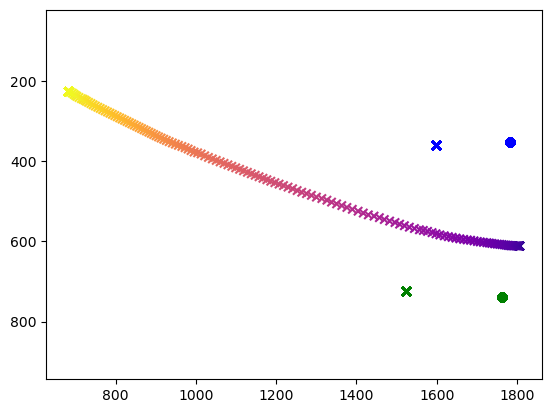

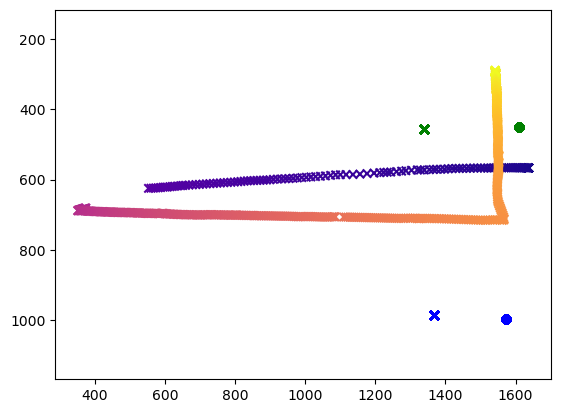

In [2252]:
# plt.figure(figsize=(1, 5))
def _():
    d0 = d0_new_t
    plt.gca().axis('equal')
    plt.scatter(d0["A__pixelx"], d0["A__pixely"], marker="x", c=d0["t"], cmap="plasma")
    plt.scatter(d0["light_1_a__pixelx"], d0["light_1_a__pixely"], marker="o", c="g")
    plt.scatter(d0["light_1_b__pixelx"], d0["light_1_b__pixely"], marker="x", c="g")
    plt.scatter(d0["light_2_a__pixelx"], d0["light_2_a__pixely"], marker="o", c="b")
    plt.scatter(d0["light_2_b__pixelx"], d0["light_2_b__pixely"], marker="x", c="b")
    plt.gca().invert_yaxis()
_()
plt.figure()
def _():
    d0 = d1_new_t
    plt.gca().axis('equal')
    plt.scatter(d0["A__pixelx"], d0["A__pixely"], marker="x", c=d0["t"], cmap="plasma")
    plt.scatter(d0["light_1_a__pixelx"], d0["light_1_a__pixely"], marker="o", c="g")
    plt.scatter(d0["light_1_b__pixelx"], d0["light_1_b__pixely"], marker="x", c="g")
    plt.scatter(d0["light_2_a__pixelx"], d0["light_2_a__pixely"], marker="o", c="b")
    plt.scatter(d0["light_2_b__pixelx"], d0["light_2_b__pixely"], marker="x", c="b")
    plt.gca().invert_yaxis()
_()

In [2253]:
d0["bench_1__pixely"].dropna().iloc[0]

396.75

In [2254]:
b1_0 = np.array([d0["bench_1__pixelx"].dropna().iloc[0], d0["bench_1__pixely"].dropna().iloc[0]])
b1_1 = np.array([d1["bench_1__pixelx"].dropna().iloc[0], d1["bench_1__pixely"].dropna().iloc[0]])
b2_0 = np.array([d0["bench_2__pixelx"].dropna().iloc[0], d0["bench_2__pixely"].dropna().iloc[0]])
b2_1 = np.array([d1["bench_2__pixelx"].dropna().iloc[0], d1["bench_2__pixely"].dropna().iloc[0]])

In [2255]:
# 1d0["bench_1__pixelx"].dropna()

In [2256]:
T_c0 = calculate_camera_pose(m0[10], calib_0)

ret True rvec [[ 0.31293135]
 [-1.07785769]
 [-0.49622936]] tvec [[12.3961521 ]
 [ 2.88121628]
 [23.91604074]]


In [2257]:
T_c0[:3, 3]

array([-21.3287611 , -16.697719  ,   0.46165886])

In [2258]:
T_c1[:3, 3]

array([-17.15766769,  18.23597775,   2.72775361])

In [2259]:
T_c1 = calculate_camera_pose(m1[10], calib_1)

ret True rvec [[-0.52807858]
 [-1.25199838]
 [ 0.66954081]] tvec [[ 9.11158357]
 [-0.97537626]
 [24.22508545]]


In [2260]:
np.linalg.norm(T_c0[:3, 3][:2])

27.087448563531467

In [2261]:
np.linalg.norm(T_c1[:3, 3][:2])

25.723175786585447

In [2262]:
def find_point_near_2rays(ray1_origin, ray1_vector, ray2_origin, ray2_vector) -> np.ndarray:
    # some geometry here
    R = ray1_origin.reshape(3, 1)
    S = ray2_origin.reshape(3, 1)
    r = ray1_vector.reshape(3, 1)
    s = ray2_vector.reshape(3, 1)
    c1 = (r.T @ r)[0][0]
    c2 = -(r.T @ s)[0][0]
    d1 = -c2
    d2 = -(s.T @ s)[0][0]
    c3 = -((R-S).T @ r)[0][0]
    d3 = -((R-S).T @ s)[0][0]
    albe = np.linalg.inv(np.array([[c1, c2], [d1, d2]])) @ np.array([[c3], [d3]])
    # print(albe)
    al, be = albe.T.flatten()
    point = np.array(((al * r + R) + (be * s + S)) / 2).reshape(3)

    # r = np.matrix(ray1_vector).T; q = np.matrix(ray1_origin).T; s = np.matrix(ray2_vector).T; p = np.matrix(ray2_origin).T
    # rrss = np.hstack([np.vstack([(r.T @ r), (r.T @ s)]), np.vstack([-(s.T @ r), -(s.T @ s)])])
    # u = np.array(np.linalg.pinv(rrss) @ np.matrix((np.array([[(p - q).T], [(p - q).T]]) @ np.array([[r], [s]]))).T).T[0]
    # point = np.array(((u[0] * r + q) + (u[1] * s + p)) / 2).reshape(3)

    return point

In [2263]:
def find_ray(T_c, calib, uv):
    vec = np.array([*cv2.undistortPoints(
        np.array(np.array(uv).reshape(2, 1),dtype="float64"),
        calib[0],
        calib[1],
    ).reshape(2), 1])

    return T_c[:3, 3], T_c[:3, :3] @ vec

In [2264]:
def find_point(p0, p1):
    o0, v0 = find_ray(T_c0, calib_0, p0)
    o1, v1 = find_ray(T_c1, calib_1, p1)
    return find_point_near_2rays(o0, v0, o1, v1)

In [2265]:
bench_1_p = find_point(b1_0, b1_1)
bench_2_p = find_point(b2_0, b2_1)

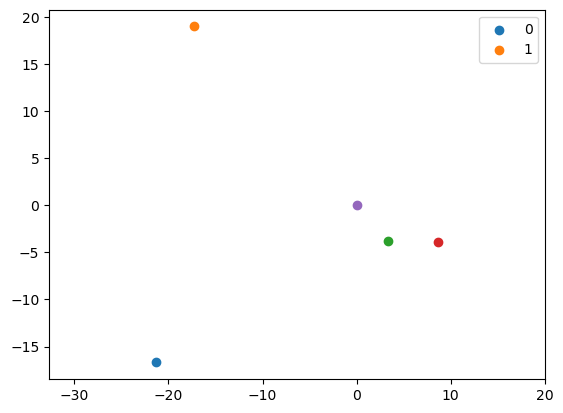

In [2266]:
plt.scatter([T_c0[:3, 3][0]], [T_c0[:3, 3][1]], label="0")
plt.scatter([T_c1[:3, 3][0]], [T_c1[:3, 3][1]], label="1")
plt.scatter([bench_1_p[0]], [bench_1_p[1]])
plt.scatter([bench_2_p[0]], [bench_2_p[1]])
plt.scatter([0], [0])
plt.gca().axis('equal')
plt.legend()

In [2267]:
np.linalg.norm(bench_1_p - bench_2_p)

5.370828097572565

In [2268]:
pnts = []
NN = len(A0)//3
for N in range(NN):
    pnts.append(find_point(A0[N], A1[N]))
pnts = np.array(pnts)

In [2269]:
# o0, v0 = find_ray(T_c0, calib_0, b1_0[N])
# o1, v1 = find_ray(T_c1, calib_1, A1[N])
# pnts.append(find_point_near_2rays(o0, v0, o1, v1))

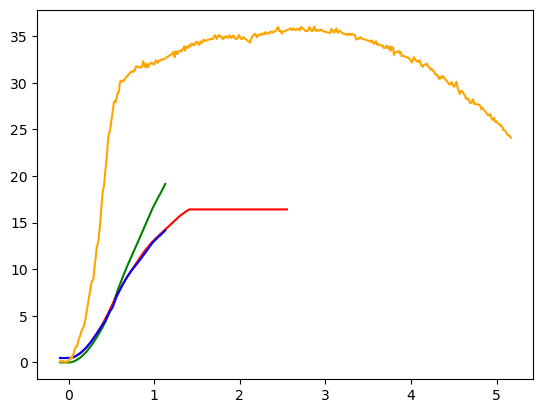

In [2270]:
plt.plot(t_new[:NN], pnts[:, 2] - pnts[0, 2], c="green")
plt.plot(t_new[:NN], d0_new_t["A__x"][:NN], c="r")
plt.plot(t_new[:NN], d1_new_t["A__x"][:NN], c="b")
plt.plot(dl_new_t["t"], dl_new_t["h"], c="orange")


In [2271]:
# plt.scatter(combo["t"], (combo["track_x"]**2 + combo["track_y"]**2)**0.5)

In [2272]:
combo = dl_new_t.copy()
combo["track_x"] = float('nan')
combo["track_y"] = float('nan')
combo["track_z"] = float('nan')
combo["camera_0_simple_z"] = d0_new_t["A__x"]
combo["camera_1_simple_z"] = d1_new_t["A__x"]



combo["track_x"].iloc[:len(pnts)] = pnts[:, 0] 
combo["track_y"].iloc[:len(pnts)] = pnts[:, 1]
combo["track_z"].iloc[:len(pnts)] = pnts[:, 2]- pnts[0, 2]

In [2273]:
import os
import sys

In [2274]:
os.makedirs(exp_dir+"/out", exist_ok=True)
combo.to_csv(exp_dir + "/out/combined.csv")

In [2275]:
pnts[:, 1].shape

(266,)

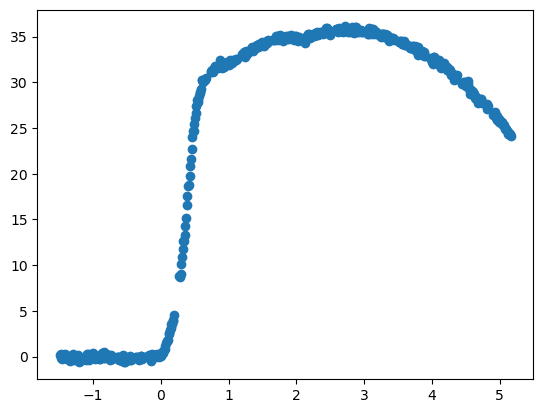

In [2276]:
plt.scatter(dl["t"], dl["h"])

In [2277]:
import pyvista as pv
pv.set_jupyter_backend('html')
# pv.set_jupyter_backend('trame')
pv.global_theme.axes.x_color = 'red'
pv.global_theme.axes.y_color = 'green'
pv.global_theme.axes.z_color = 'blue'
# pv.set_jupyter_backend('client')
# pv.global_theme.jupyter_backend = "panel"


p = pv.Plotter()

p.add_text("Mesh", font_size=24)
axes = pv.Axes(show_actor=True,actor_scale=2, line_width=5)
axes.axes_actor.x_axis_shaft_properties.color = (1, 0, 0)
axes.axes_actor.y_axis_shaft_properties.color = (0, 1, 0)
axes.axes_actor.z_axis_shaft_properties.color = (0, 0, 1)
axes.origin = (0, 0, 0)
axes.actor.user_matrix = T_c0
p.add_actor(axes.actor)
axes = pv.Axes(show_actor=True,actor_scale=2, line_width=5)
axes.axes_actor.x_axis_shaft_properties.color = (1, 0, 0)
axes.axes_actor.y_axis_shaft_properties.color = (0, 1, 0)
axes.axes_actor.z_axis_shaft_properties.color = (0, 0, 1)
axes.origin = (0, 0, 0)
axes.actor.user_matrix = T_c1
p.add_actor(axes.actor)
p.add_actor(pv.Axes(show_actor=True,actor_scale=5, line_width=2).actor)

# for N in range(40):
    
#     o, v = find_ray(T_c0, calib_0, A0[N])
#     actor = p.add_lines(o + np.array([v*i for i in np.linspace(0, 30, 2)]), color='purple', width=3)

#     o, v = find_ray(T_c1, calib_1, A1[N])
actor = p.add_points(pnts, color='green')
actor = p.add_points(np.array([bench_1_p, bench_2_p]), color='red')
# # p.camera = camera
# p.add_mesh(mesh)

p.show()


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

In [2278]:
m0[0]

array([[1763.264 ,  739.553 ],
       [1522.173 ,  724.6778],
       [1781.227 ,  352.2349],
       [1598.794 ,  360.9356]])